Stroke Prediction using Incremental clustering

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Mount Gdrive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Set current working directory
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
import os
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
import os
print(os.listdir("../Colab Notebooks"))

['hand-on.ipynb', 'Household_LSTM.ipynb', 'DL_Pneuminia', 'healthcare-dataset-stroke-data.csv', 'Untitled0.ipynb']


In [ ]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
df = data.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# drop unnecessary columns
df.drop(["id"], axis = 1, inplace = True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# data info: columns with data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [ ]:
# bmi column seems it has null values. Let's check it out!
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
How many target variables of both "stroke" or "not stroke" classes on the dataset?

Object `dataset` not found.


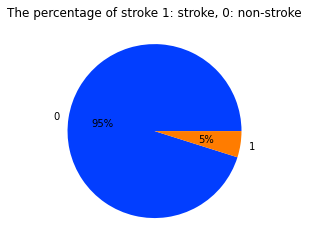

In [ ]:
data = df["stroke"].value_counts()
labels = df["stroke"].value_counts().index

palette_color = sns.color_palette('bright')
plt.pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.title("The percentage of stroke 1: stroke, 0: non-stroke");

Issues:
There is 201 null BMI values on the dataset. Additionally the data is imbalance therefore we need to solve these issues for better results.

Data Visualization

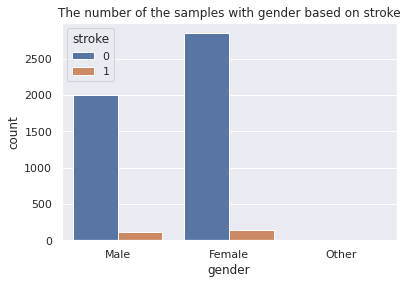

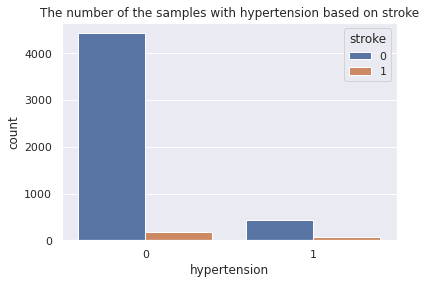

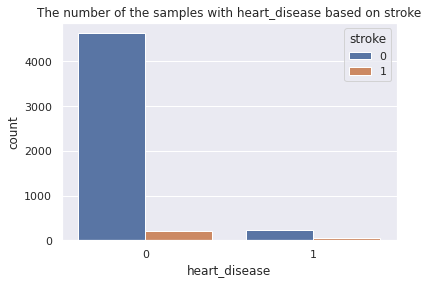

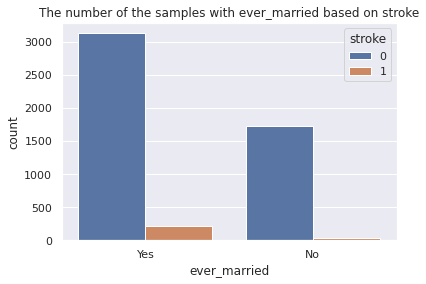

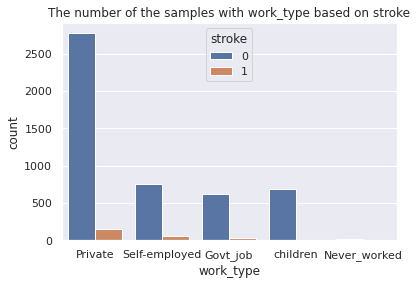

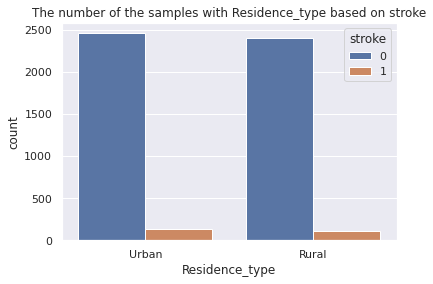

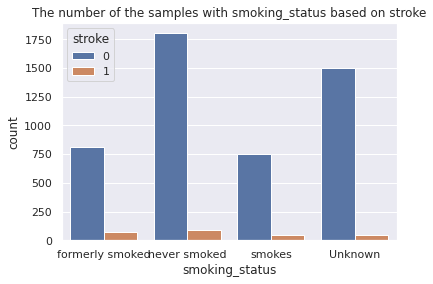

In [ ]:
# a short look into the number of each categorical features grouped by stroke variable.
sns.set_theme(style = 'darkgrid')
for i in df.columns[:-1]:  # exclude stroke column
    if (df[i].dtype == 'object') or (df[i].dtype == 'int64'):
            sns.countplot(data = df, x = i, hue = 'stroke')
            plt.title('The number of the samples with {} based on stroke'.format(i))
            plt.show()

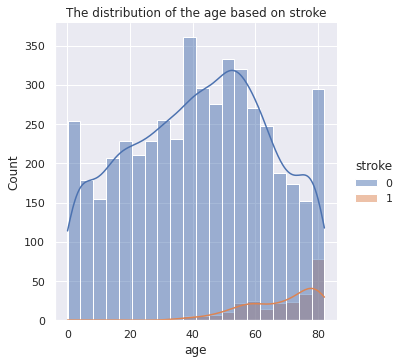

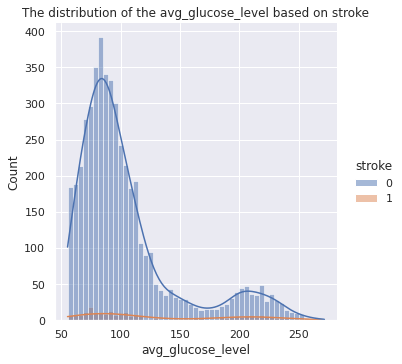

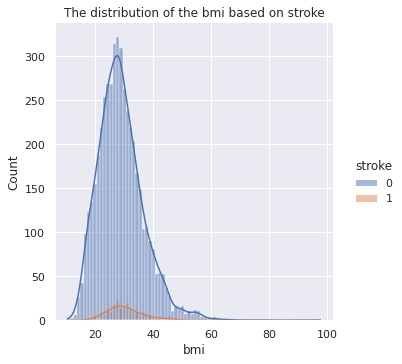

In [ ]:
# a short look into numeric variables like bmi, avg_glucose_level and age
sns.set_theme(style = 'darkgrid')
for i in df.columns[:-1]: # exclude stroke column
    if df[i].dtype == 'float64':
            sns.displot(data = df, x = i, hue = 'stroke', kde = True)
            plt.title('The distribution of the {} based on stroke'.format(i))
            plt.show()

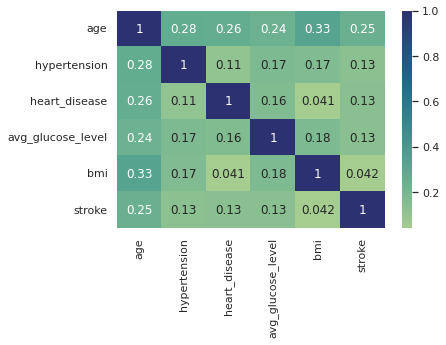

In [ ]:
# Correlation heatmap
sns.heatmap(df.corr(), annot = True, cmap = 'crest')

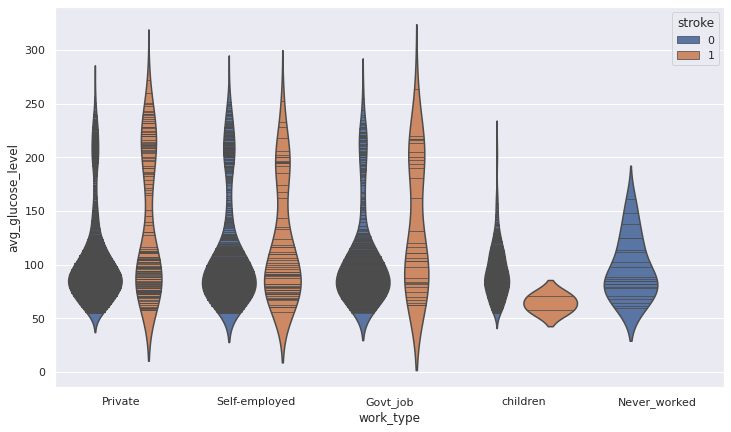

In [ ]:
# Violin plot to visualize each numerical variables by stroke
plt.figure(figsize = (12, 7))
sns.violinplot(data = df, x = "work_type", y="avg_glucose_level", hue = 'stroke', inner = 'stick')
plt.show()

Encoding, Missing Value Imputation and Oversampling

Encoding

In [ ]:
# First we need to transform our columns to be encoded to numpy arrays
gender = df.iloc[:,0:1].values
ever_married = df.iloc[:,4].values
work_type = df.iloc[:,5:6].values
residence_type = df.iloc[:,6].values
smoking_status = df.iloc[:,9:10].values

In [ ]:
# Other variables
age = df[["age"]]
hypertension = df[["hypertension"]]
heart_disease = df[["heart_disease"]]
avg_glucose_level = df[["avg_glucose_level"]]
bmi = df[["bmi"]]
stroke = df[["stroke"]]

In [ ]:
unique, counts = np.unique(ever_married, return_counts = True)
print(np.asarray((unique, counts)).T)

[['No' 1757]
 ['Yes' 3353]]


In [ ]:
# Label Encoding for ever_married and residence_type columns which has two labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ever_married = le.fit_transform(ever_married)
ever_married = pd.DataFrame(ever_married, columns = ["ever_married"])
print("Labels 0, 1:",le.classes_)
residence_type = le.fit_transform(residence_type)
residence_type = pd.DataFrame(residence_type, columns = ["residence_type"])
print("Labels 0, 1:",le.classes_)

Labels 0, 1: ['No' 'Yes']
Labels 0, 1: ['Rural' 'Urban']


In [ ]:
# One Hot Encoding for gender, work_type and smoking status columns
ohe = OneHotEncoder(dtype = np.int64, sparse = False)
gender = ohe.fit_transform(gender)
gender = pd.DataFrame(gender, columns = ['female', 'male', 'other'])
print("Gender dummies respectively 0, 1, 2:", ohe.categories_)
work_type = ohe.fit_transform(work_type)
work_type = pd.DataFrame(work_type, columns = ['govt_job', 'never_worked', 'private', 'self-employed', 'children'])
print("Work type dummies respectively 0, 1, 2, 3, 4:", ohe.categories_)
smoking_status = ohe.fit_transform(smoking_status)
smoking_status = pd.DataFrame(smoking_status, columns = ['unknown', 'formerly_smoked', 'never_smoked', 'smokes'])
print("Smoking status dummies respectively 0, 1, 2, 3:", ohe.categories_)

Gender dummies respectively 0, 1, 2: [array(['Female', 'Male', 'Other'], dtype=object)]
Work type dummies respectively 0, 1, 2, 3, 4: [array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
      dtype=object)]
Smoking status dummies respectively 0, 1, 2, 3: [array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
      dtype=object)]


In [ ]:
frames = [gender, age, hypertension, heart_disease, ever_married, work_type, residence_type, avg_glucose_level, bmi, smoking_status, stroke]
df_en = pd.concat(frames, axis = 1)
df_en.head(3)

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,avg_glucose_level,bmi,unknown,formerly_smoked,never_smoked,smokes,stroke
0,0,1,0,67.0,0,1,1,0,0,1,0,0,1,228.69,36.6,0,1,0,0,1
1,1,0,0,61.0,0,0,1,0,0,0,1,0,0,202.21,NaN,0,0,1,0,1
2,0,1,0,80.0,0,1,1,0,0,1,0,0,0,105.92,32.5,0,0,1,0,1


Missing Value Imputation

In [ ]:
# Missing value solution with Simple Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')
df_en = pd.DataFrame(imputer.fit_transform(df_en), columns = df_en.columns)
df_en.head()

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,avg_glucose_level,bmi,unknown,formerly_smoked,never_smoked,smokes,stroke
0,0.0,1.0,0.0,67.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,228.69,36.600000,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,61.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,202.21,28.893237,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,80.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,105.92,32.500000,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,49.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,171.23,34.400000,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,79.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,174.12,24.000000,0.0,0.0,1.0,0.0,1.0


In [ ]:
int_vars = ["female","male","other","age","hypertension","heart_disease","ever_married","govt_job","never_worked","private","self-employed",
            "children", "residence_type","unknown","formerly_smoked","never_smoked","smokes"]

df1 = df_en[int_vars].astype(np.int64)
num_vars = ["avg_glucose_level","bmi"]
df2 = df_en[num_vars]
label = ["stroke"]
df3 = df_en[label]
df_en = pd.concat([df1, df2, df3], axis = 1)
df_en

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,unknown,formerly_smoked,never_smoked,smokes,avg_glucose_level,bmi,stroke
0,0,1,0,67,0,1,1,0,0,1,0,0,1,0,1,0,0,228.69,36.600000,1.0
1,1,0,0,61,0,0,1,0,0,0,1,0,0,0,0,1,0,202.21,28.893237,1.0
2,0,1,0,80,0,1,1,0,0,1,0,0,0,0,0,1,0,105.92,32.500000,1.0
3,1,0,0,49,0,0,1,0,0,1,0,0,1,0,0,0,1,171.23,34.400000,1.0
4,1,0,0,79,1,0,1,0,0,0,1,0,0,0,0,1,0,174.12,24.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,0,0,80,1,0,1,0,0,1,0,0,1,0,0,1,0,83.75,28.893237,0.0
5106,1,0,0,81,0,0,1,0,0,0,1,0,1,0,0,1,0,125.20,40.000000,0.0
5107,1,0,0,35,0,0,1,0,0,0,1,0,0,0,0,1,0,82.99,30.600000,0.0
5108,0,1,0,51,0,0,1,0,0,1,0,0,0,0,1,0,0,166.29,25.600000,0.0


In [ ]:
df_en.isnull().sum()

female               0
male                 0
other                0
age                  0
hypertension         0
heart_disease        0
ever_married         0
govt_job             0
never_worked         0
private              0
self-employed        0
children             0
residence_type       0
unknown              0
formerly_smoked      0
never_smoked         0
smokes               0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64

Oversampling with Synthetic Minority Oversampling Technique (SMOTE)
Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

Source: [https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/]

In [ ]:
from imblearn.over_sampling import SMOTE
X, y = df_en.iloc[:, 0:-1], df_en.iloc[:, -1:]

print("Before Oversampling, the counts of label 1: ", y.value_counts()[1])
print("Before Oversampling, the counts of label 0: ", y.value_counts()[0])

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

print("After Oversampling, the counts of label 1: ", y.value_counts()[1])
print("After Oversampling, the counts of label 0: ", y.value_counts()[0])

Before Oversampling, the counts of label 1:  249
Before Oversampling, the counts of label 0:  4861
After Oversampling, the counts of label 1:  4861
After Oversampling, the counts of label 0:  4861


Data Visualization After Oversampling

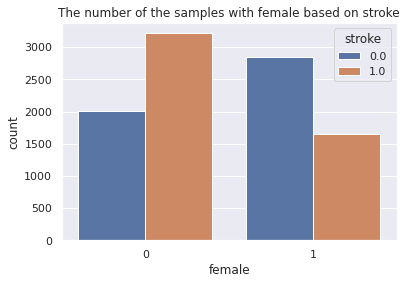

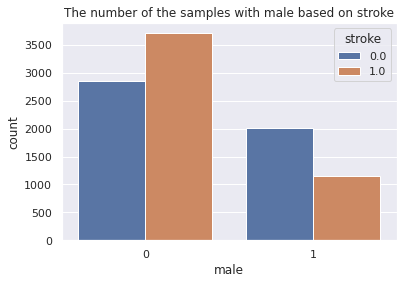

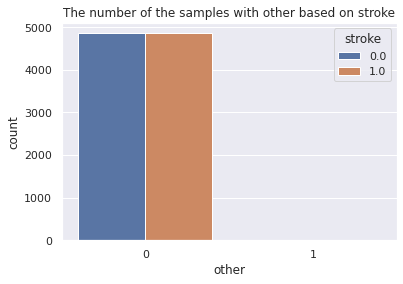

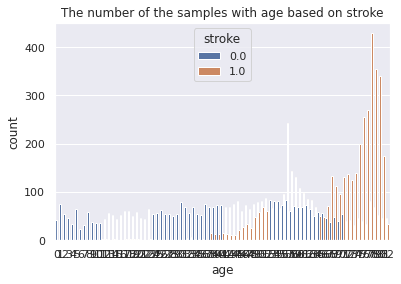

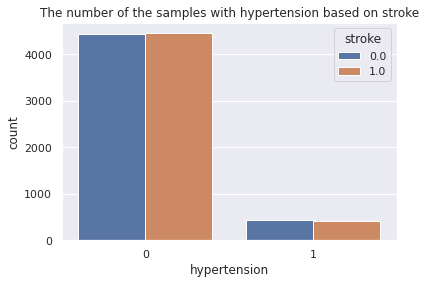

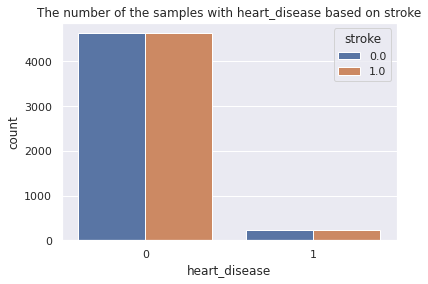

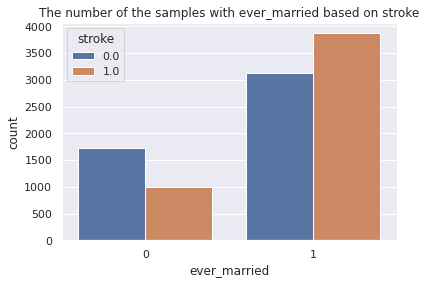

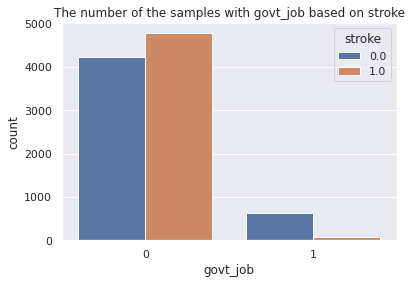

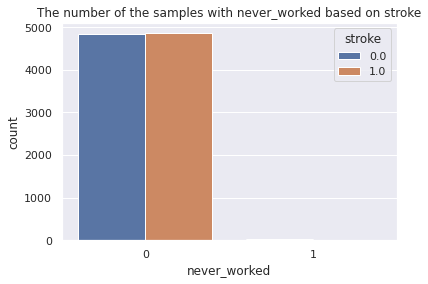

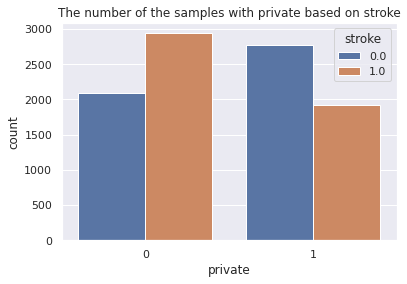

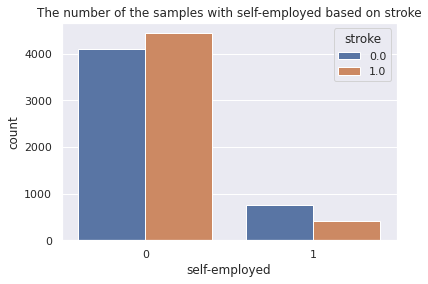

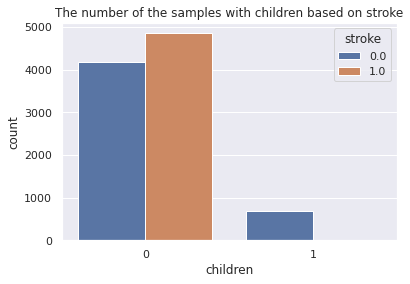

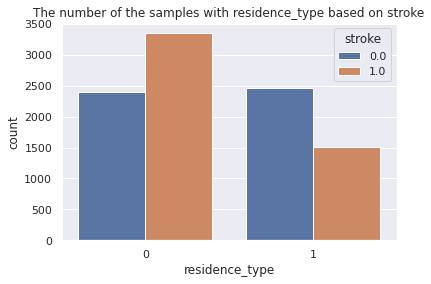

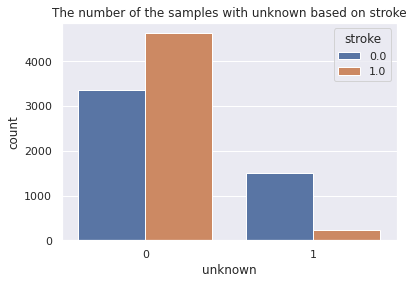

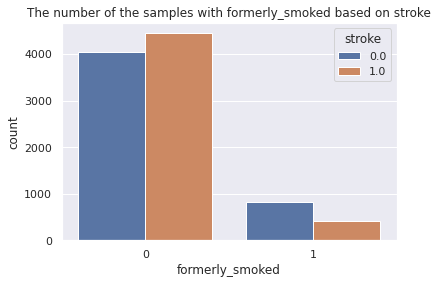

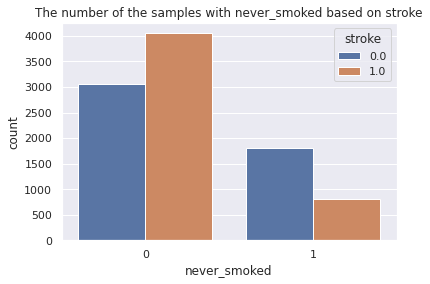

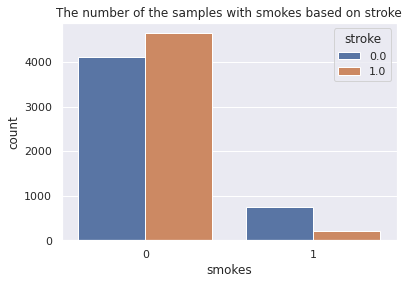

In [ ]:
# visualization after SMOTE
df_as = pd.concat([X, y], axis = 1)

# a short look into the number of each categorical features grouped by stroke variable.
sns.set_theme(style = 'darkgrid')
for i in df_as.columns[:-1]:  # exclude stroke column
    if (df_as[i].dtype == 'object') or (df_as[i].dtype == 'int64'):
            sns.countplot(data = df_as, x = i, hue = 'stroke')
            plt.title('The number of the samples with {} based on stroke'.format(i))
            plt.show()

We can easily see that stroke 1 labels are increased after SMOTE

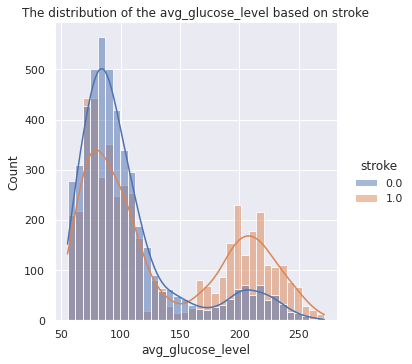

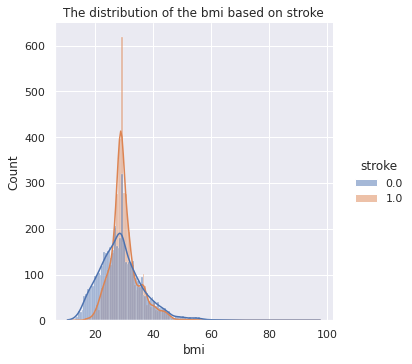

In [ ]:
sns.set_theme(style = 'darkgrid')
for i in df_as.columns[:-1]: # exclude stroke column
    if df_as[i].dtype == 'float64':
            sns.displot(data = df_as, x = i, hue = 'stroke', kde = True)
            plt.title('The distribution of the {} based on stroke'.format(i))
            plt.show()

Splitting Data and Feature Scaling


In [ ]:
# Splitting data to validation and training
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Scaling features between -1 and 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:

#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

#Importing the dataset
dataset = pd.read_csv('healthcare-dataset-stroke-data.csv')
X = dataset.iloc[:, [0, 1]].values
y = dataset.iloc[:, 2].values

#Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

#Fitting classifier to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

#Predicting the Test set results
y_pred = classifier.predict(X_test)

#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

#Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Naive Bayes (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

#Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Naive Bayes (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()


"\n#Importing the libraries\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport sklearn\nfrom sklearn.model_selection import train_test_split\nfrom sklearn import datasets\nfrom sklearn import svm\n\n#Importing the dataset\ndataset = pd.read_csv('healthcare-dataset-stroke-data.csv')\nX = dataset.iloc[:, [0, 1]].values\ny = dataset.iloc[:, 2].values\n\n#Splitting the dataset into the Training set and Test set\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)\n\n#Feature Scaling\nfrom sklearn.preprocessing import StandardScaler\nsc = StandardScaler()\nX_train = sc.transform(X_train)\nX_test = sc.transform(X_test)\n\n#Fitting classifier to the Training set\nfrom sklearn.naive_bayes import GaussianNB\nclassifier = GaussianNB()\nclassifier.fit(X_train, y_train)\n\n#Predicting the Test set results\ny_pred = classifier.predict(X_test)\n\n#Making the Confusion Matrix\nfrom sklearn.metrics import confusion_matrix\ncm = c

In [ ]:
def incremental_clustering(X, k):

    #Incrementally cluster a dataset.

    Parameters
    X : array-like. shape = [n_samples, n_features]

    k : int

    Returns
    labels : array-like. shape = [n_samples]


    # Initialize variables
    labels = np.zeros(X.shape[0], dtype=np.int)
    centroids = []

    # Iterate over the dataset
    for i in range(X.shape[0]):
        # Find the nearest centroid
        distances = []

'def incremental_clustering(X, k):\n    \n    #Incrementally cluster a dataset.\n    \n    Parameters\n    X : array-like. shape = [n_samples, n_features]\n\n    k : int\n    \n    Returns\n    labels : array-like. shape = [n_samples]\n        \n    \n    # Initialize variables\n    labels = np.zeros(X.shape[0], dtype=np.int)\n    centroids = []\n    \n    # Iterate over the dataset\n    for i in range(X.shape[0]):\n        # Find the nearest centroid\n        distances = []'

In [ ]:
!pip install sklearn plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.3 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=40d3231b9e99dadbf28131b5dff50e6197ffc278c8d605b94d8321cd4e560b5b
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=28d3097e7c200776d0605cf370d84a5f7b5123f24043dee7a2751d3814d011e0
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built sklearn typing


In [ ]:
# Models with hyperparameters to be tuned
grid_models = [(LogisticRegression(),[{'C' : [0.3, 0.7, 1], 'random_state' : [42]}]),
               (DecisionTreeClassifier(),[{'criterion' : ['gini','entropy'], 'random_state' : [42]}]),
               (RandomForestClassifier(),[{'n_estimators' : [100, 200, 300], 'criterion' : ['gini','entropy'], 'random_state' : [42]}]),
               (LinearDiscriminantAnalysis(),[{'solver' : ['svd', 'lsqr', 'eigen']}]),
               (AdaBoostClassifier(),[{'n_estimators' : [50, 100, 150], 'random_state' : [42]}]),
               (KNeighborsClassifier(),[{'n_neighbors' : [4, 6, 8, 10], 'metric' : ['euclidean', 'manhattan', 'chebyshev','minkowski']}]),
               (SVC(),[{'C' : [0.3, 0.7, 1], 'kernel' : ['rbf','linear','polynomial'], 'random_state' : [42]}]),
               (XGBClassifier(),[{'max_depth' : [3, 5, 7], 'min_child_weight' : [1, 3, 5]}]),
               (CatBoostClassifier(),[{'n_estimators' : [100, 200, 300], 'max_depth' : [3,5,7]}])]

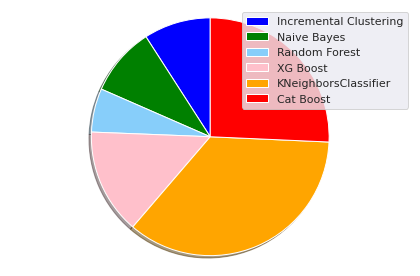

In [ ]:
import matplotlib.pyplot as plt

labels = ['Incremental Clustering', 'Naive Bayes', 'Random Forest', 'XG Boost','KNeighborsClassifier','Cat Boost']
sizes = [9.2, 9.45, 6, 14.5, 36.0, 26]
colors = ['blue', 'green', 'lightskyblue', 'pink','orange','red']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
Incremental =['9.2', '9.45', '6', '14.5', '36.0', '26']

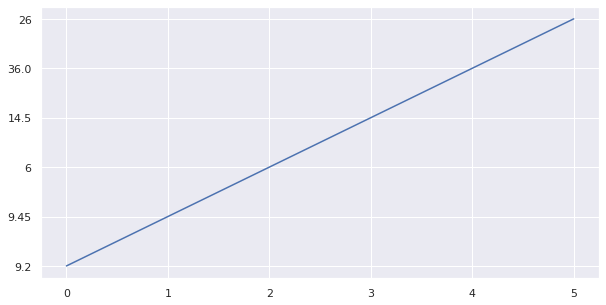

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Incremental)